# Data-sources exploration using `eo-learn`

This notebook shows some examples on how to retrieve EO and non-EO data using `eo-learn`. 

The steps are as follow:
 * split area of interest into easy-to-process EOPatches
 * add Sentinel-2 imaging data
 * add vector and raster data from OSM
 * add Sentinel-1 imaging data

Add generic packages

In [1]:
%matplotlib inline

import os
from pathlib import Path

from matplotlib import dates
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely.geometry import Polygon, box, shape, mapping
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import overpass  # This one is not an eo-learn dependency and has to be additionally installed

Set path to data

In [2]:
data_dir = Path('..', 'data')
os.listdir(data_dir)

['.ipynb_checkpoints', 'denmark.geojson', 'statapi_kranj.geojson']

`eo-learn` and `sentinelhub` imports

In [3]:
from eolearn.core import EOTask, EOPatch, FeatureType
from eolearn.io import SentinelHubInputTask, SentinelHubEvalscriptTask
from eolearn.geometry import VectorToRasterTask

C:\Users\mracic\AppData\Local\Continuum\anaconda3\envs\eo-learn-workshop\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from sentinelhub import BBoxSplitter, BBox, CRS, DataCollection

## 1. Split country into smaller bounding boxes <a id='splitter'></a>

Load shapefile of Denmark

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

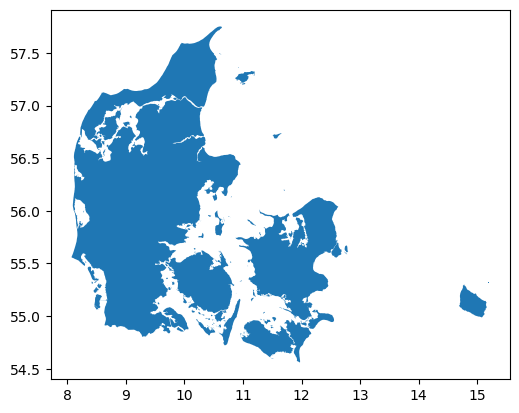

In [5]:
country_filename = data_dir / 'denmark.geojson'
country = gpd.read_file(country_filename)

country.plot()
country.crs

Set CRS to UTM

<Derived Projected CRS: EPSG:32632>
Name: WGS 84 / UTM zone 32N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 6°E and 12°E, northern hemisphere between equator and 84°N, onshore and offshore. Algeria. Austria. Cameroon. Denmark. Equatorial Guinea. France. Gabon. Germany. Italy. Libya. Liechtenstein. Monaco. Netherlands. Niger. Nigeria. Norway. Sao Tome and Principe. Svalbard. Sweden. Switzerland. Tunisia. Vatican City State.
- bounds: (6.0, 0.0, 12.0, 84.0)
Coordinate Operation:
- name: UTM zone 32N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

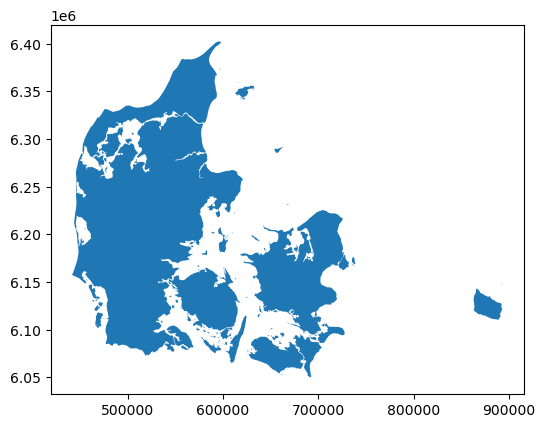

In [6]:
country_crs = CRS.UTM_32N
country = country.to_crs(country_crs.pyproj_crs())

country.plot()
country.crs

Get size of country in pixels to decide number and size of bounding boxes

In [7]:
country_shape = country.geometry.values[-1]

width_pix = int((country_shape.bounds[2] - country_shape.bounds[0]) / 10)
height_pix = int((country_shape.bounds[3] - country_shape.bounds[1]) / 10)

print(f'Dimension of the area is {width_pix} x {height_pix} pixels')

Dimension of the area is 45105 x 35243 pixels


Split area into 45x35 boxes bounding 

In [8]:
bbox_splitter = BBoxSplitter([country_shape], country_crs, (45, 35))

In [9]:
geometry = [bbox.geometry for bbox in bbox_splitter.get_bbox_list()]
bbox_list = bbox_splitter.get_bbox_list()
idxs_x = [info['index_x'] for info in bbox_splitter.get_info_list()]
idxs_y = [info['index_y'] for info in bbox_splitter.get_info_list()]

gdf = gpd.GeoDataFrame(
    {'index_x':idxs_x, 'index_y':idxs_y},
    geometry=[bbox.geometry for bbox in bbox_list],
    crs=bbox_list[0].crs.pyproj_crs()
)

gdf.head()

index_x  index_y                                           geometry
0        0       10  POLYGON ((441745.630 6150469.905, 441745.630 6...
1        0       11  POLYGON ((441745.630 6160539.386, 441745.630 6...
2        0       12  POLYGON ((441745.630 6170608.866, 441745.630 6...
3        0       13  POLYGON ((441745.630 6180678.347, 441745.630 6...
4        0       14  POLYGON ((441745.630 6190747.828, 441745.630 6...

Plot results

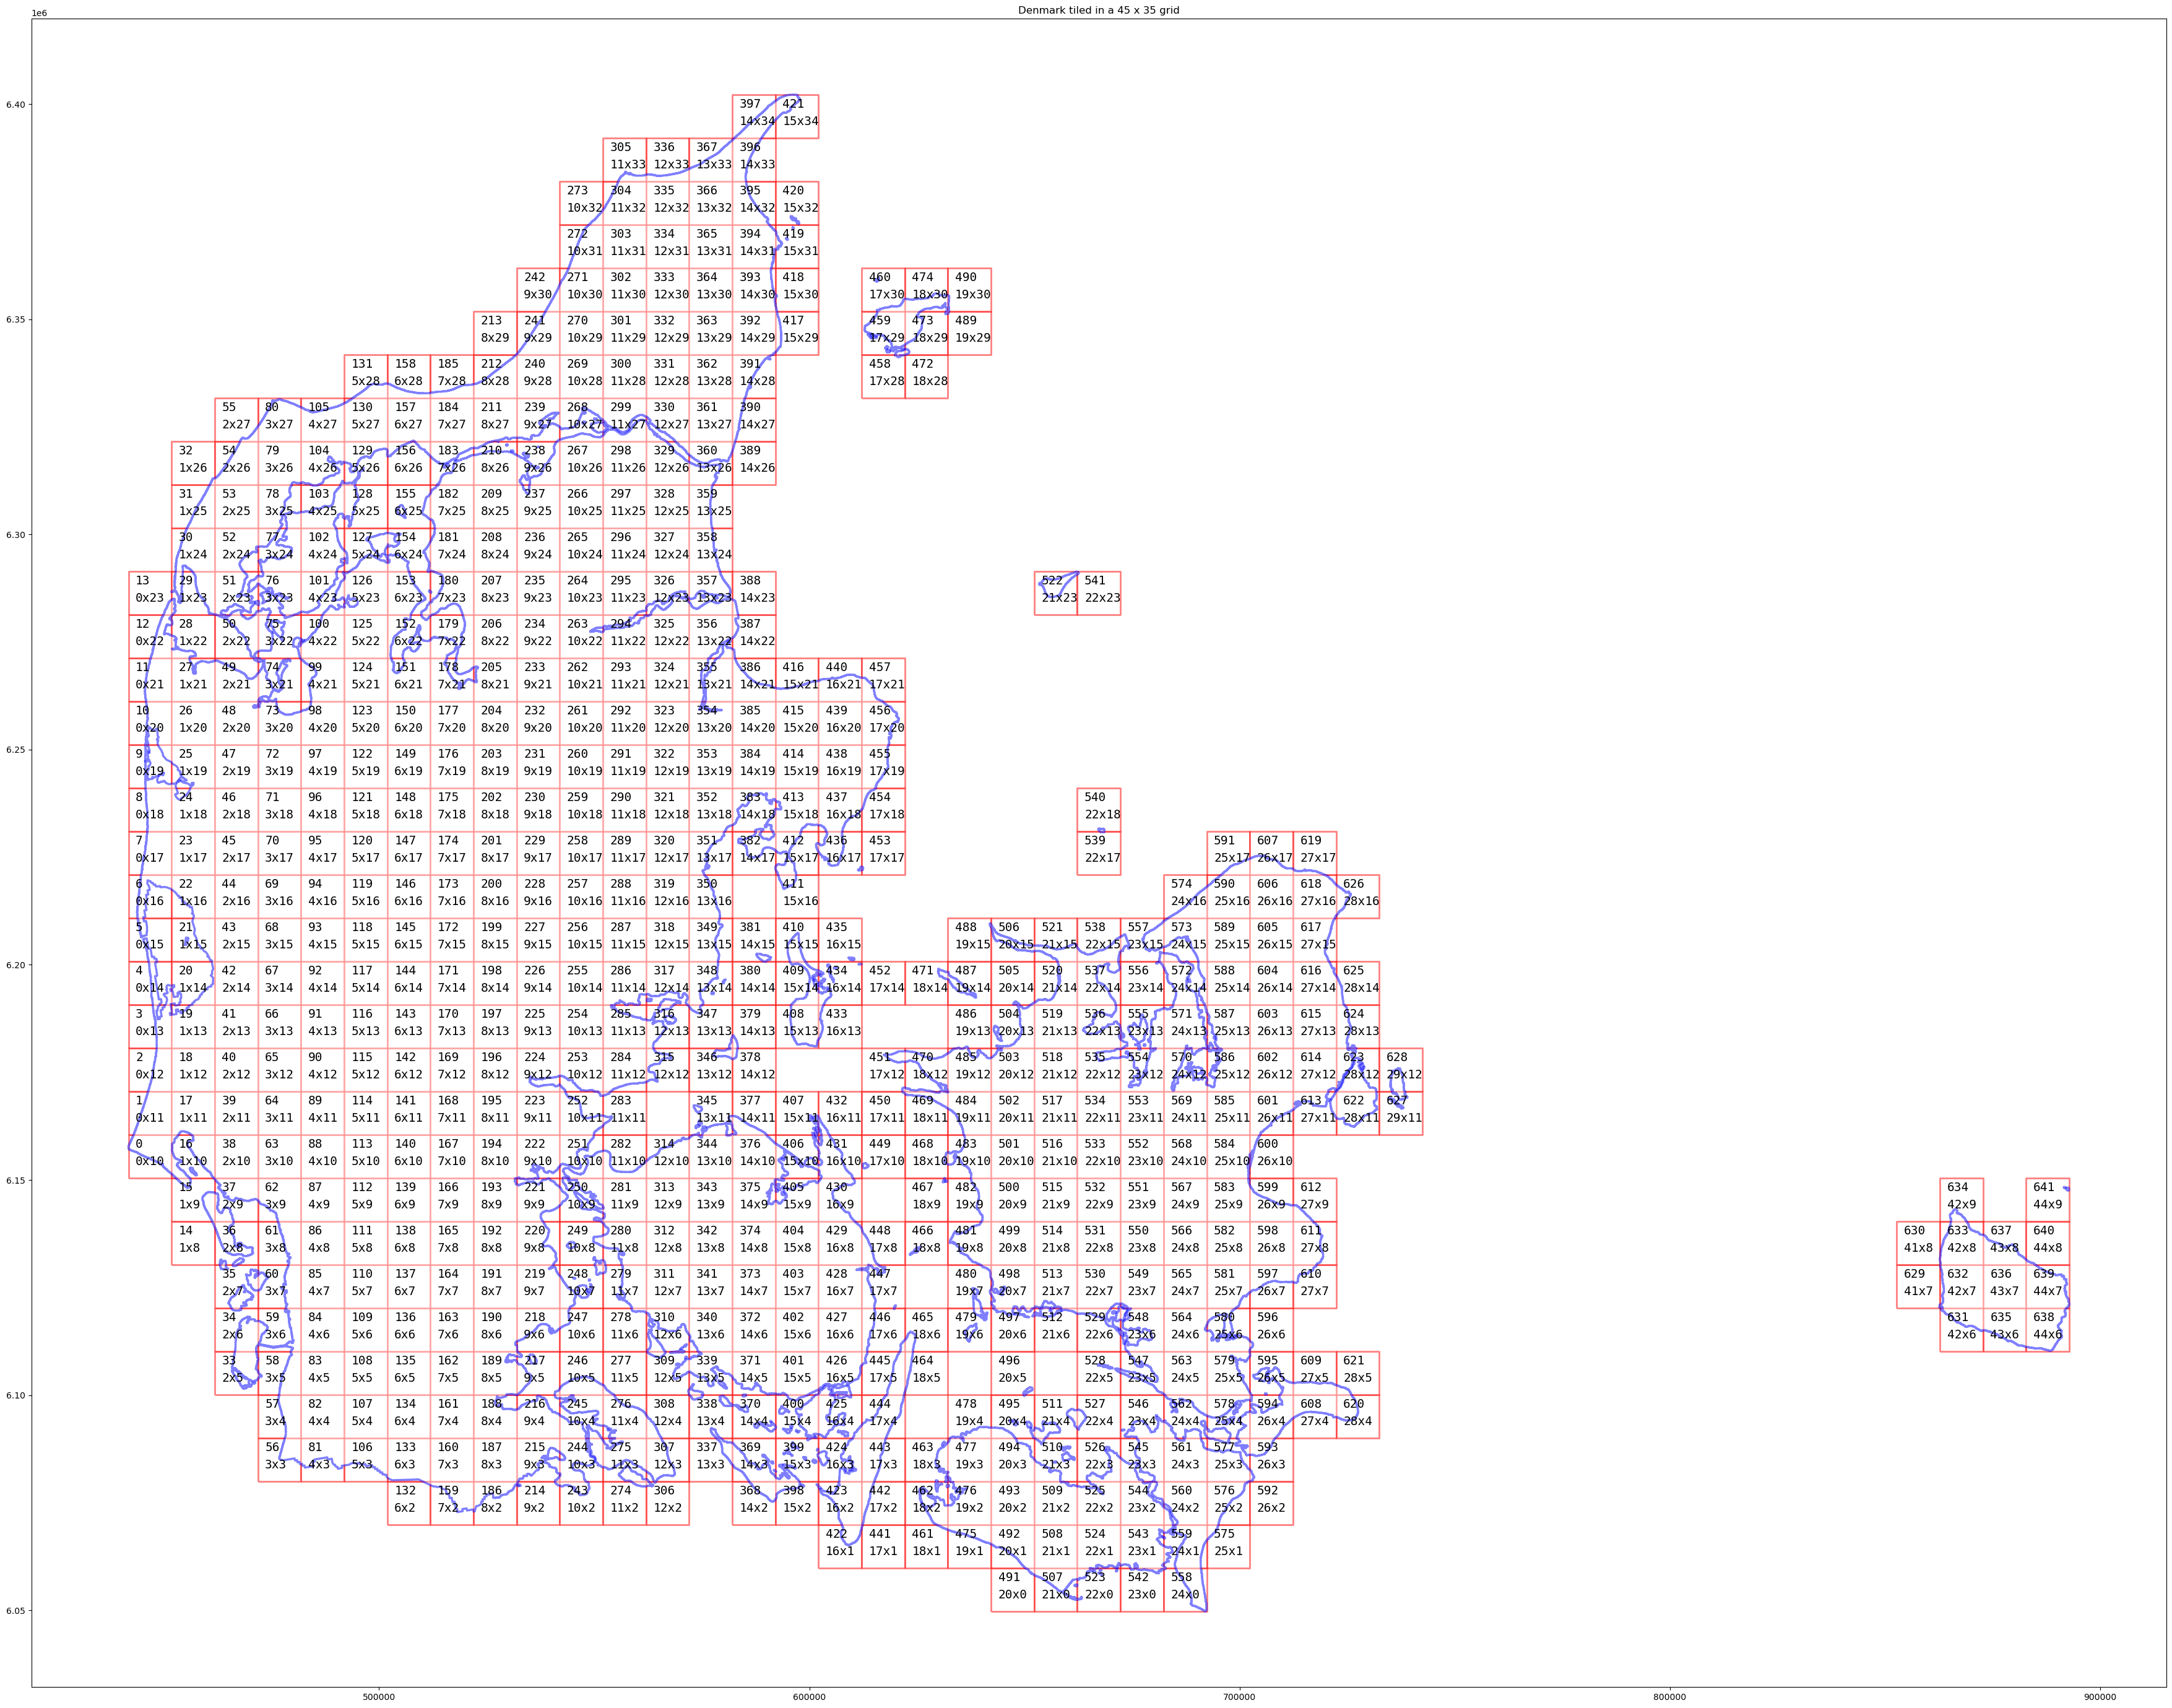

In [10]:
# if bboxes have all same size, estimate offset
xl, yl, xu, yu = gdf.geometry[0].bounds
xoff, yoff = (xu - xl) / 3, (yu - yl) / 5

# figure
fig, ax = plt.subplots(figsize=(45,35))
gdf.plot(ax=ax, facecolor='w', edgecolor='r', alpha=0.5, linewidth=2)
country.plot(ax=ax, facecolor='w', edgecolor='b', alpha=0.5, linewidth=2.5)
ax.set_title('Denmark tiled in a 45 x 35 grid');

# add annotiation text
fontdict = {'family': 'monospace', 'weight': 'normal', 'size': 14}
for idx in gdf.index:
    eop_name = '{0}x{1}'.format(gdf.index_x[idx], gdf.index_y[idx])
    centroid, = list(gdf.geometry[idx].centroid.coords)
    ax.text(centroid[0] - xoff, centroid[1] + yoff, str(idx), fontdict=fontdict)
    ax.text(centroid[0] - xoff, centroid[1] - yoff, eop_name, fontdict=fontdict)

## 2. Retrieve S2 L1C data <a id="sentinel-2"></a>

In [11]:
s2_rgb_task = SentinelHubInputTask(
    data_collection=DataCollection.SENTINEL2_L1C,
    bands=['B04', 'B03', 'B02'],
    bands_feature=(FeatureType.DATA, 'S2-RGB'),
    additional_data=[(FeatureType.MASK, 'dataMask')],
    resolution=(10, 10),
    maxcc=0.1
)

In [12]:
ndvi_evalscript = """
//VERSION=3

function setup() {
  return {
    input: ["B04", "B08"],
    output:[
      {
        id: "ndvi",
        bands: 1,
        sampleType: SampleType.FLOAT32
      },
    ]
  }
}

function evaluatePixel(sample) {
  let ndvi = index(sample.B08, sample.B04);
  return {
    ndvi: [ndvi],
  };
}
"""

s2_ndvi_task = SentinelHubEvalscriptTask(
    features=[(FeatureType.DATA, 'ndvi', 'NDVI')],
    evalscript=ndvi_evalscript,
    data_collection=DataCollection.SENTINEL2_L1C,
    resolution=(10, 10),
    maxcc=0.1
)

In [13]:
time_interval = ['2019-05-01','2019-09-01']
idx = 436
bbox = bbox_splitter.bbox_list[idx]

Download TRUE-COLOR

In [14]:
#!sentinelhub.config --instance_id 533118a6-c8bb-49ce-98cc-2bdd536cf1d8
#!sentinelhub.config --sh_client_id 3d55f47a-0640-4bf4-b9d5-4fe1eaf691a2 --sh_client_secret !aMxX2~+E{!l6,~wvBW7hHt>IZo2iBnWPlzYCISN

In [15]:
!sentinelhub.config --show

{
  "instance_id": "82594f36-1583-4b78-8e39-d5d74610bb23",
  "sh_client_id": "3d55f47a-0640-4bf4-b9d5-4fe1eaf691a2",
  "sh_client_secret": "!aMxX2~+E{!l6,~wvBW7hHt>IZo2iBnWPlzYCISN",
  "sh_base_url": "https://services.sentinel-hub.com",
  "sh_auth_base_url": "https://services.sentinel-hub.com",
  "geopedia_wms_url": "https://service.geopedia.world",
  "geopedia_rest_url": "https://www.geopedia.world/rest",
  "aws_access_key_id": "",
  "aws_secret_access_key": "",
  "aws_session_token": "",
  "aws_metadata_url": "https://roda.sentinel-hub.com",
  "aws_s3_l1c_bucket": "sentinel-s2-l1c",
  "aws_s3_l2a_bucket": "sentinel-s2-l2a",
  "opensearch_url": "http://opensearch.sentinel-hub.com/resto/api/collections/Sentinel2",
  "max_wfs_records_per_query": 100,
  "max_opensearch_records_per_query": 500,
  "max_download_attempts": 4,
  "download_sleep_time": 5.0,
  "download_timeout_seconds": 120.0,
  "number_of_download_processes": 1
}
Configuration file location: C:\Users\mracic\AppData\Local\Con

In [16]:
eopatch = s2_rgb_task.execute(bbox=bbox, time_interval=time_interval)

eopatch

EOPatch(
  data={
    S2-RGB: numpy.ndarray(shape=(19, 1007, 1002, 3), dtype=float32)
  }
  mask={
    dataMask: numpy.ndarray(shape=(19, 1007, 1002, 1), dtype=bool)
  }
  meta_info={
    maxcc: 0.1
    size_x: 1002
    size_y: 1007
    time_difference: 1.0
    time_interval: ('2019-05-01T00:00:00', '2019-09-01T23:59:59')
  }
  bbox=BBox(((602120.9239705771, 6220956.269831697), (612144.3798617239, 6231025.750548924)), crs=CRS('32632'))
  timestamp=[datetime.datetime(2019, 5, 23, 10, 45, 14), ..., datetime.datetime(2019, 8, 31, 10, 45, 16)], length=19
)

Download NDVI

In [17]:
eopatch = s2_ndvi_task.execute(eopatch)

eopatch

EOPatch(
  data={
    NDVI: numpy.ndarray(shape=(19, 1007, 1002, 1), dtype=float32)
    S2-RGB: numpy.ndarray(shape=(19, 1007, 1002, 3), dtype=float32)
  }
  mask={
    dataMask: numpy.ndarray(shape=(19, 1007, 1002, 1), dtype=bool)
  }
  meta_info={
    maxcc: 0.1
    size_x: 1002
    size_y: 1007
    time_difference: 1.0
    time_interval: '..'
  }
  bbox=BBox(((602120.9239705771, 6220956.269831697), (612144.3798617239, 6231025.750548924)), crs=CRS('32632'))
  timestamp=[datetime.datetime(2019, 5, 23, 10, 45, 14), ..., datetime.datetime(2019, 8, 31, 10, 45, 16)], length=19
)

In [18]:
eopatch.timestamp

[datetime.datetime(2019, 5, 23, 10, 45, 14),
 datetime.datetime(2019, 5, 25, 10, 35, 26),
 datetime.datetime(2019, 5, 28, 10, 45, 19),
 datetime.datetime(2019, 6, 4, 10, 35, 26),
 datetime.datetime(2019, 6, 7, 10, 45, 18),
 datetime.datetime(2019, 6, 7, 10, 45, 23),
 datetime.datetime(2019, 6, 14, 10, 35, 25),
 datetime.datetime(2019, 6, 17, 10, 45, 18),
 datetime.datetime(2019, 6, 22, 10, 45, 14),
 datetime.datetime(2019, 6, 29, 10, 35, 18),
 datetime.datetime(2019, 6, 29, 10, 35, 22),
 datetime.datetime(2019, 7, 9, 10, 35, 19),
 datetime.datetime(2019, 7, 9, 10, 35, 23),
 datetime.datetime(2019, 7, 24, 10, 35, 22),
 datetime.datetime(2019, 7, 24, 10, 35, 26),
 datetime.datetime(2019, 8, 3, 10, 35, 22),
 datetime.datetime(2019, 8, 11, 10, 45, 14),
 datetime.datetime(2019, 8, 31, 10, 45, 11),
 datetime.datetime(2019, 8, 31, 10, 45, 16)]

Plot RGB of time frames

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


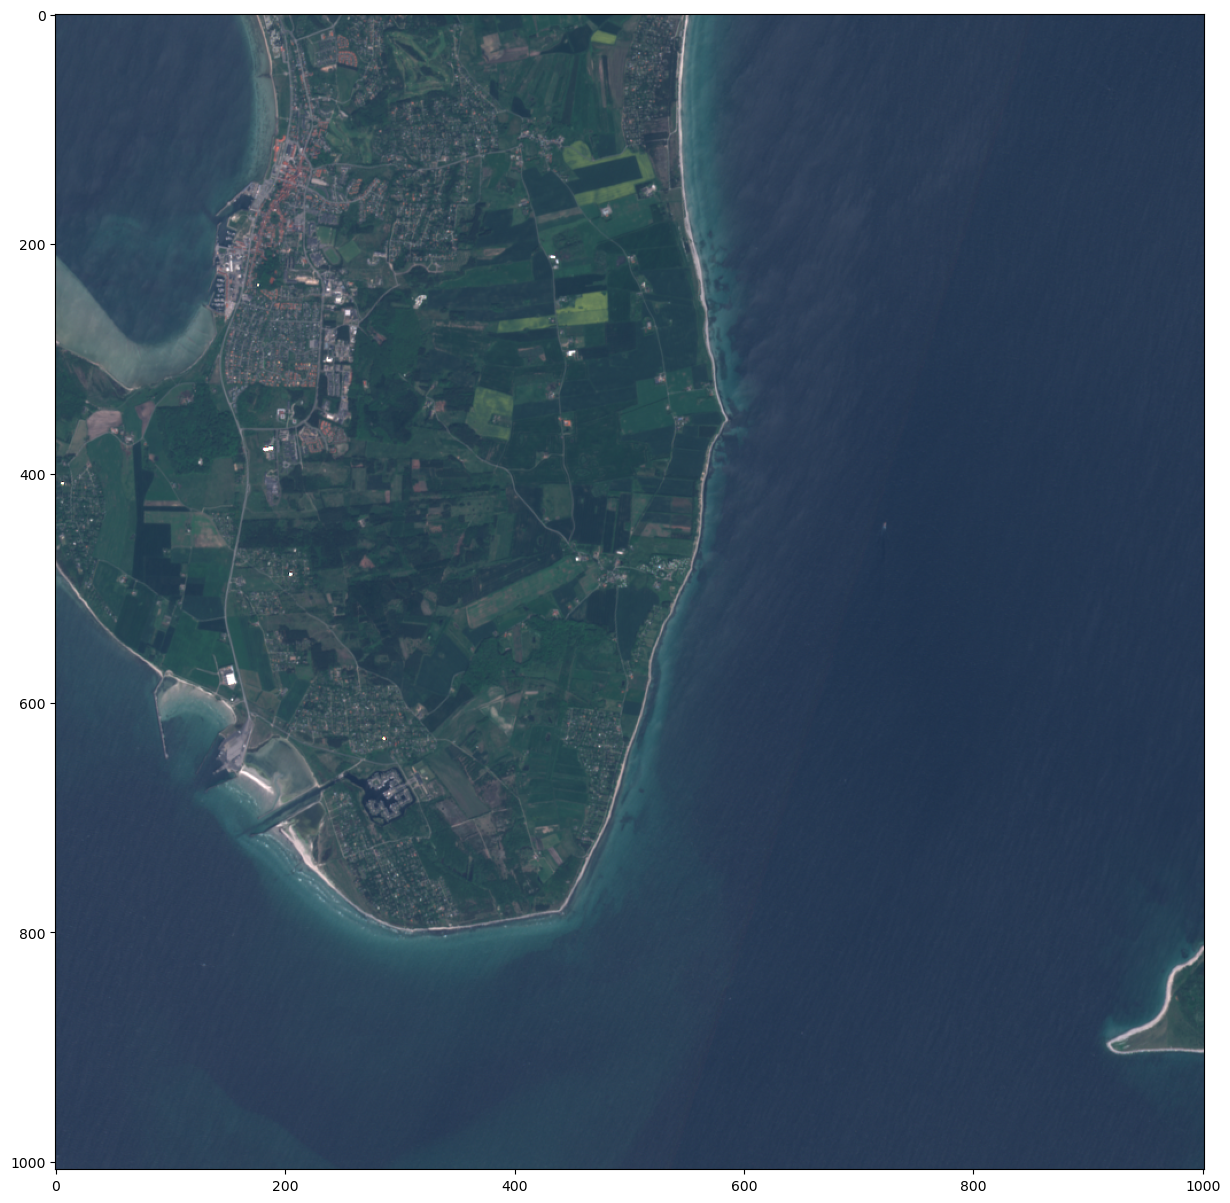

In [19]:
time_idx = 0

rgb = eopatch.data['S2-RGB']

fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(rgb[time_idx] * 3.5);

Plot the median RGB values

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


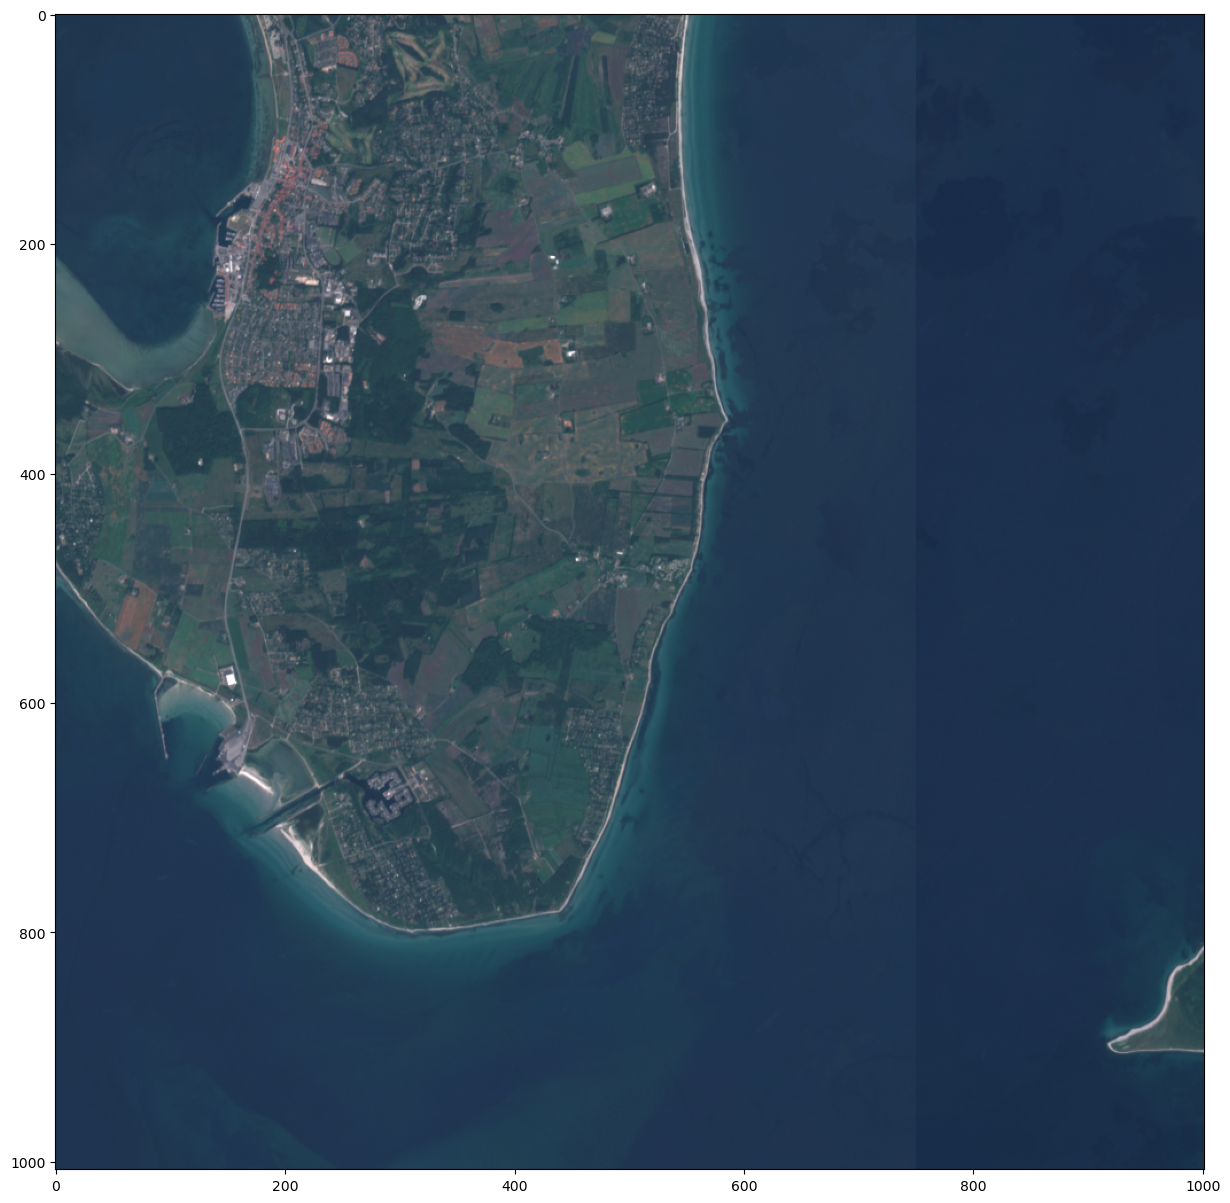

In [20]:
fig, ax = plt.subplots(figsize=(15, 15))

ax.imshow(np.median(rgb, axis=0).squeeze() * 3.5);

Plot the median NDVI values

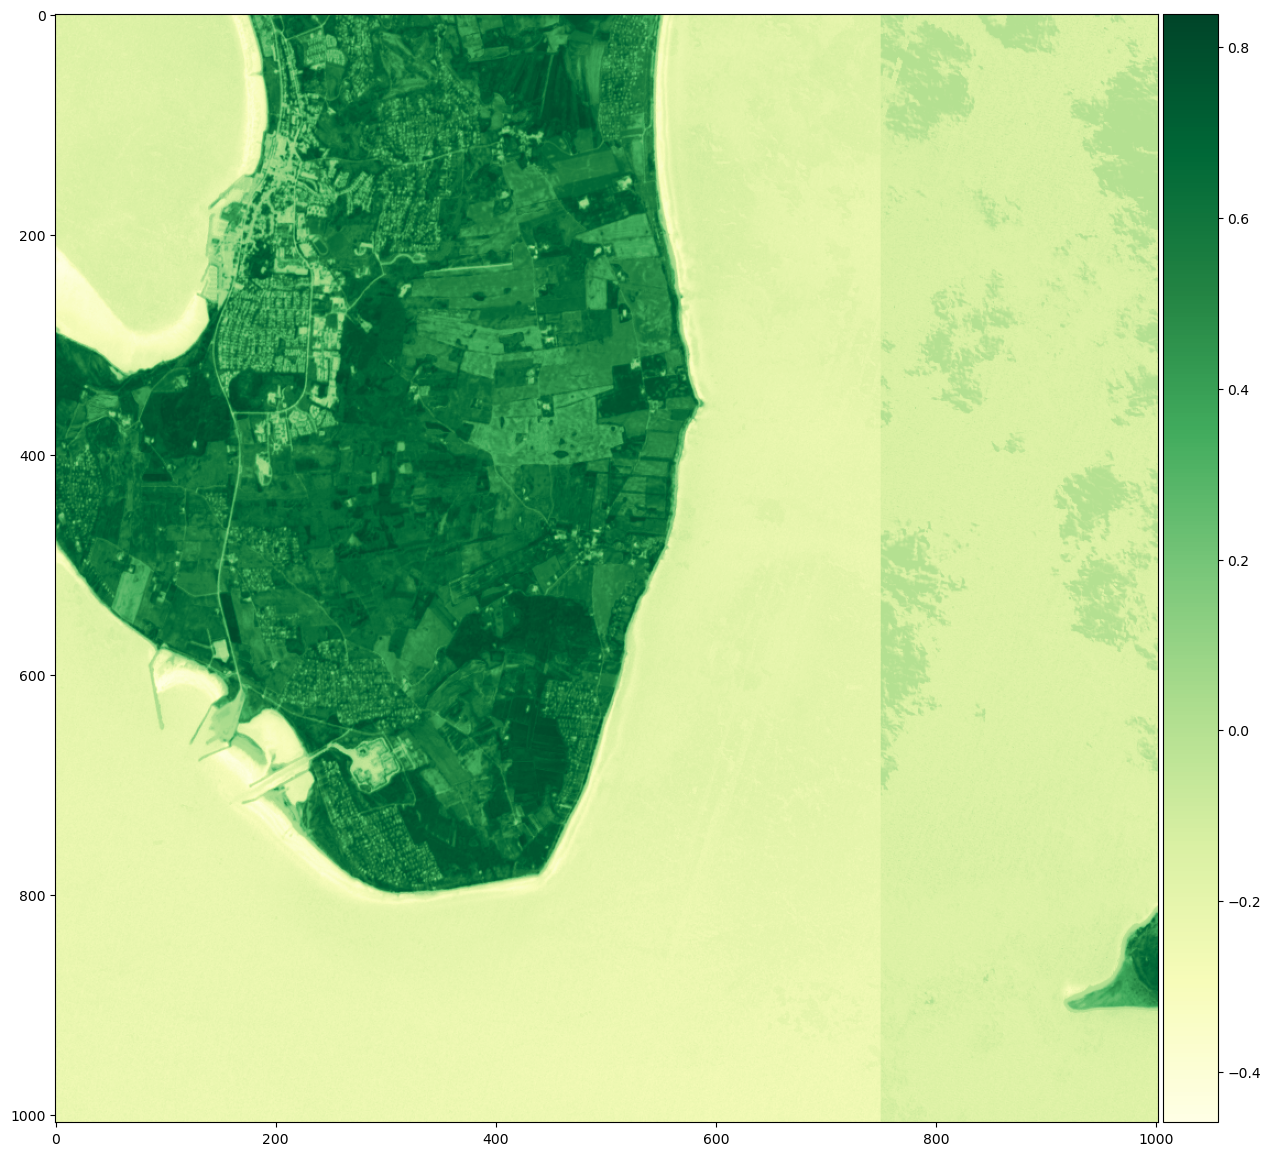

In [21]:
ndvi = eopatch.data['NDVI']
median_ndvi = np.median(ndvi, axis=0).squeeze()

fig, ax = plt.subplots(figsize=(15,15))
im = ax.imshow(median_ndvi, cmap=plt.cm.YlGn)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical');

Plot temporal NDVI of a given location

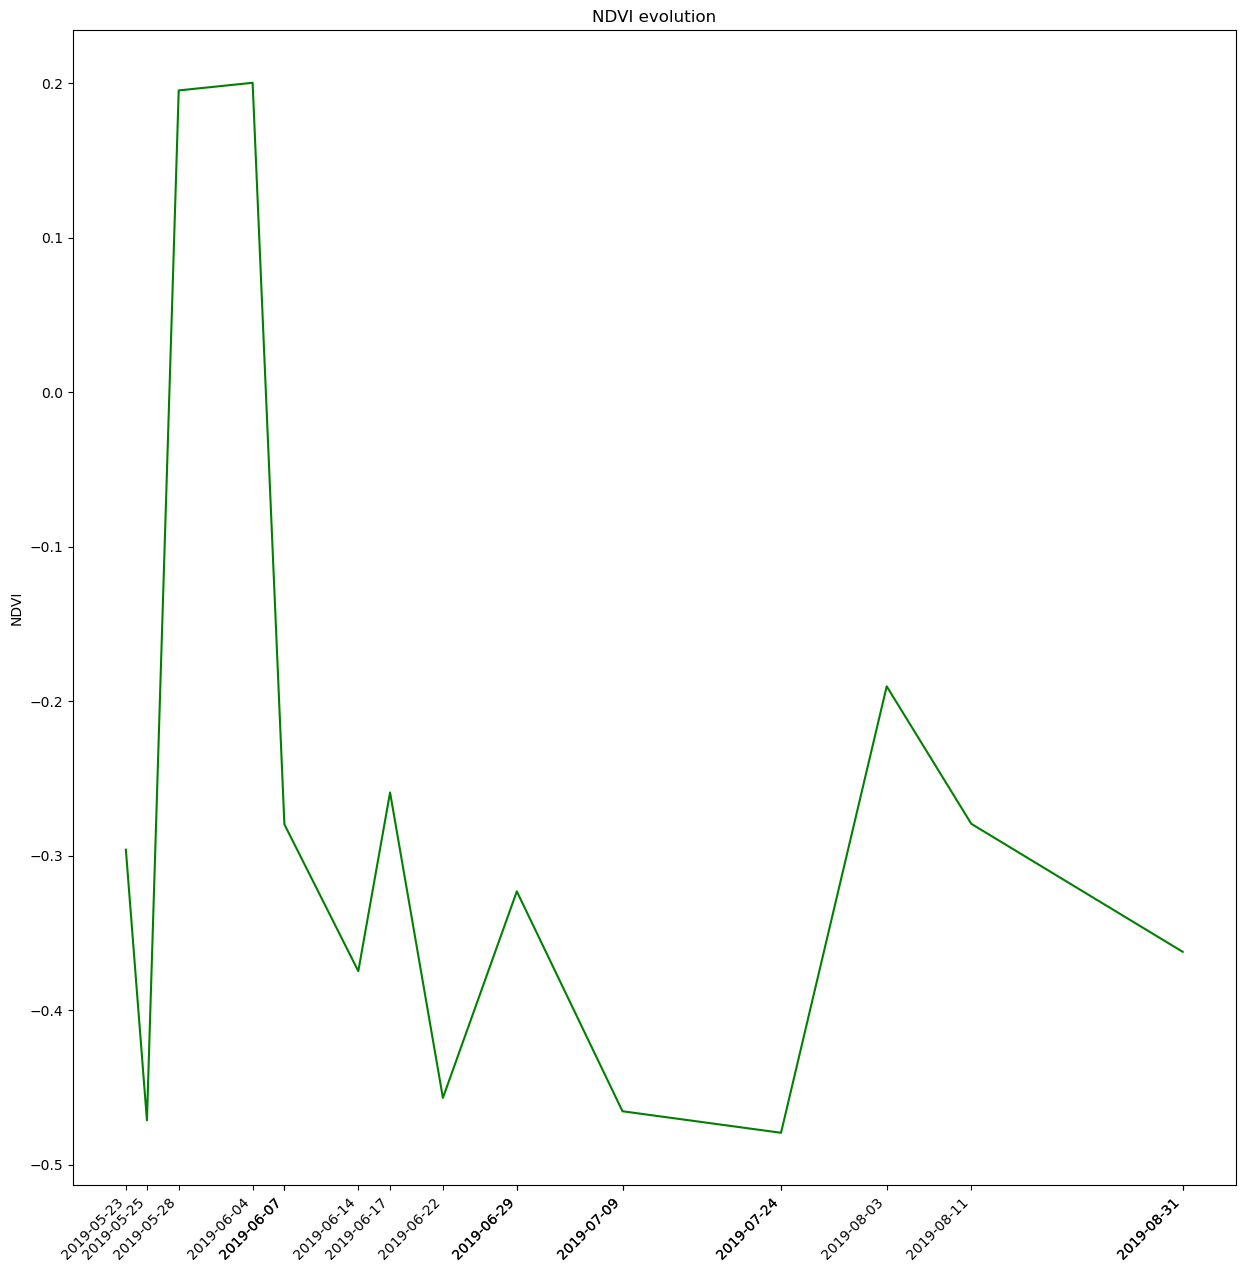

In [22]:
dates_num = dates.date2num(eopatch.timestamp)
dates_str = [timestamp.date().isoformat() for timestamp in eopatch.timestamp]

fig, ax = plt.subplots(figsize=(15, 15))
ax.plot(dates_num, ndvi[:, 100, 550, :].squeeze(), 'g')

ax.set_title('NDVI evolution')
ax.set_xticks(dates_num);
ax.set_xticklabels(dates_str, rotation=45, ha='right');
ax.set_ylabel('NDVI');